In [1]:
# Python 3.9.5
# qpsolvers 4.0.0
# SCS 3.2.3
# Mosek 10.1

In [2]:
%matplotlib inline

In [3]:
from grale.all_nb import *
import urllib.request

lenses.experimentalThreads = True

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [4]:
cl0024Model = lenses.GravitationalLens.fromBytes(urllib.request.urlopen("https://github.com/j0r1/LensModels/blob/master/2008MNRAS.389..415L_CL0024/mainresult_fig2_fig3.lensdata?raw=true").read())
cl0024ModelMonopole = lenses.GravitationalLens.fromBytes(urllib.request.urlopen("https://github.com/j0r1/LensModels/raw/master/2008MNRAS.389..415L_CL0024/monopoledegenresult_fig7.lensdata").read())
src1 = images.ImagesData.fromBytes(urllib.request.urlopen("https://github.com/j0r1/LensModels/raw/master/2008MNRAS.389..415L_CL0024/source1entire.imgdata").read())
src2 = images.ImagesData.fromBytes(urllib.request.urlopen("https://github.com/j0r1/LensModels/raw/master/2008MNRAS.389..415L_CL0024/source2entire.imgdata").read())

In [5]:
cosm = cosmology.Cosmology(0.71, 0.27, 0, 0.73)
zd, zs, zs2 = 0.395, 1.675, 1.3
critDens = lenses.getCriticalDensity(cosm.getAngularDiameterDistance(zd), cosm.getAngularDiameterDistance(zs),
                                     cosm.getAngularDiameterDistance(zd, zs))

In [6]:
lensInfo = plotutil.LensInfo(cl0024Model, size=120*ANGLE_ARCSEC, zd=zd, zs=zs, cosmology=cosm)

In [7]:
HW, N = 100, 128
bl = -V(HW,HW)*ANGLE_ARCSEC
tr = V(HW,HW)*ANGLE_ARCSEC

B = 5
densMask = np.zeros((N,N), dtype=bool)
densMask[:B,:] = True
densMask[-B:,:] = True
densMask[:,:B] = True
densMask[:,-B:] = True

origDens = cl0024Model.getSurfaceMassDensity(util.createThetaGrid(bl,tr,N,N))

commonParams = { "bottomLeft": bl, "topRight": tr, "NX": N, "NY": N, "maskRegions": [ src1, src2],
                 "potentialGradientWeight": 0.1, "densityWeight": 0.0, "densityGradientWeight": 100,
                 "feedbackObject": "stdout",
                 "exactDensityConstraints": [
                     { 
                       "density": 0, 
                       "maskRegions": [
                           densMask
                       ]
                     }
                 ]
               }

_getSurfaceMassDensity1_new


In [8]:
res_mosek = lenses.createEquivalentPotentialGridLens(cl0024Model, #_pot, 
                                                   **commonParams, qpsolver="mosek")

STATUS: Calculating lens potential values
_getProjectedPotential1_new
_getProjectedPotential1_new
_getProjectedPotential1_new
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 30.2 seconds


In [9]:
newModel = res_mosek["philens_equiv"]
lensInfoNew = plotutil.LensInfo(newModel, size=120*ANGLE_ARCSEC, zd=zd, zs=zs, cosmology=cosm)

In [10]:
lensInfoMono = plotutil.LensInfo(cl0024ModelMonopole, size=120*ANGLE_ARCSEC, zd=zd, zs=zs, cosmology=cosm)

In [11]:
iws = inversion.InversionWorkSpace(zd, 100*ANGLE_ARCSEC, cosmology=cosm)
iws.addImageDataToList(src1, zs, "extendedimages")
iws.addImageDataToList(src2, zs2, "extendedimages")

In [12]:
def plotImagePlane(li, linestyle="-", color="red", lw=1, plotImages=True):
    li.setSourceRedshift(zs)
    ip = li.getImagePlane()
    for l in ip.getCriticalLines():
        l = np.array(l)/ANGLE_ARCSEC
        plt.plot(l[:,0], l[:,1], linestyle, color=color, lw=lw)

    if plotImages:
        for imgs in src1, src2:
            allPts = np.array([ p["position"] for img in imgs.getAllImagePoints() for p in img ])
            plt.plot(allPts[:,0]/ANGLE_ARCSEC, allPts[:,1]/ANGLE_ARCSEC, 's', ms=0.01, color='black' )
    
    plt.gca().set_xlim([50,-50])
    plt.gca().set_ylim([-50,50])
    plt.gca().set_xticks([ -40, -20, 0, 20, 40 ])
    plt.gca().set_yticks([ -40, -20, 0, 20, 40])
    plt.gca().set_xlabel(r"$\theta_x$ (arcsec)")
    plt.gca().set_ylabel(r"$\theta_y$ (arcsec)")
    plt.gca().set_aspect("equal")

In [13]:
def plot2DDensity(li, hasYlabel = True):
    zMax = 3
    #plotutil.plotDensity(li, densityUnit=critDens, axImgCallback=lambda a: plt.colorbar(a, fraction=0.04575, pad=0.04))
    plotutil.plotDensityContours(li, densityUnit=critDens, levels=np.arange(0.2, zMax, 0.2), linewidths=0.5, colors="black", linestyles="-")
    plotutil.plotDensityContours(li, densityUnit=critDens, levels=[1], linewidths=[2], colors="black")
    plt.gca().invert_xaxis()
    plt.gca().set_xlim([50,-50])
    plt.gca().set_ylim([-50,50])
    plt.gca().set_xticks([ -40, -20, 0, 20, 40 ])
    plt.gca().set_yticks([ -40, -20, 0, 20, 40])
    plt.gca().set_xlabel(r"$\theta_x$ (arcsec)")
    if hasYlabel:
        plt.gca().set_ylabel(r"$\theta_y$ (arcsec)")
    
def plot2DDensity_old(li, hasCbar=True, hasYlabel=True):
    zMax = 3
    cb = None if not hasCbar else lambda a: plt.colorbar(a, fraction=0.04575, pad=0.04)
    plotutil.plotDensity(li, densityUnit=critDens, axImgCallback=cb, vmax=zMax)
    plotutil.plotDensityContours(li, densityUnit=critDens, levels=np.arange(0.2, zMax, 0.2), linewidths=0.5, cmap="gray_r", linestyles="dotted")
    plotutil.plotDensityContours(li, densityUnit=critDens, levels=[1], linewidths=[2], cmap="gray_r")
    
    plt.gca().invert_xaxis()
    plt.gca().set_xlim([50,-50])
    plt.gca().set_ylim([-50,50])
    plt.gca().set_xticks([ -40, -20, 0, 20, 40 ])
    plt.gca().set_yticks([ -40, -20, 0, 20, 40])
    plt.gca().set_xlabel(r"$\theta_x$ (arcsec)")
    if hasYlabel:
        plt.gca().set_ylabel(r"$\theta_y$ (arcsec)")
    

Text(value='')

FloatProgress(value=0.0)

Text(value='')

FloatProgress(value=0.0)

Text(value='')

FloatProgress(value=0.0)

Text(value='')

FloatProgress(value=0.0)

Text(value='')

Text(value='')

FloatProgress(value=0.0)

Text(value='')

Text(value='')

FloatProgress(value=0.0)

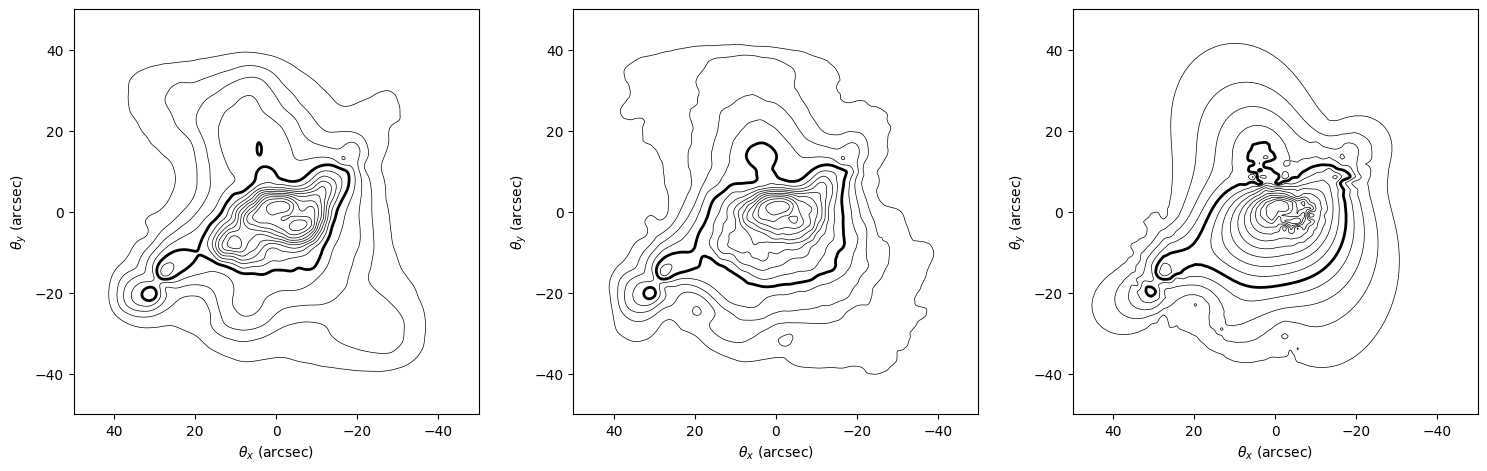

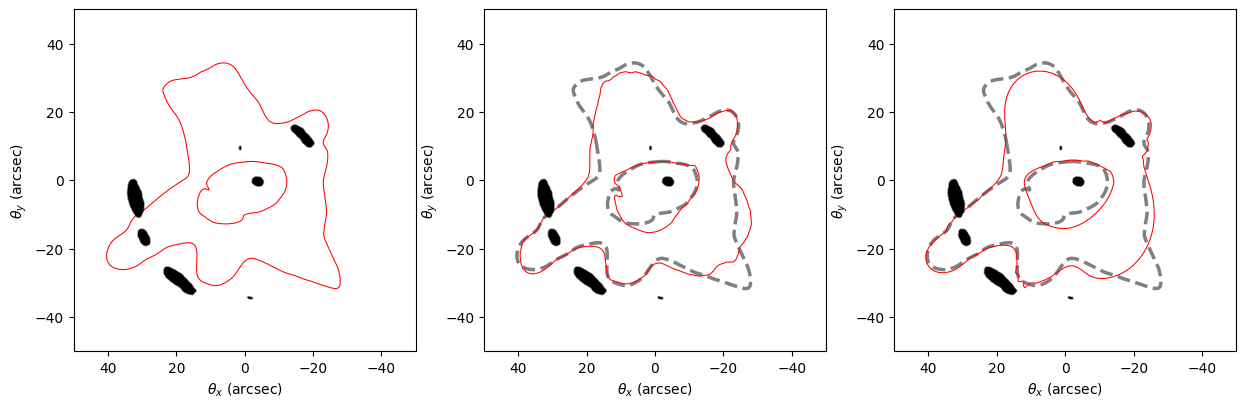

In [14]:
fig = plt.figure(figsize=(15,5))
for idx,li in enumerate([ lensInfo, lensInfoMono, lensInfoNew ]):

    ax = fig.add_axes([idx*0.333,0,0.27,1])
    #plt.subplot(1,3,idx+1)
    
    plot2DDensity(li)
    

fig = plt.figure(figsize=(15,5))
for idx,li in enumerate([ lensInfo, lensInfoMono, lensInfoNew ]):    
    plt.subplot(1,3,idx+1)
    if li is not lensInfo:
        plotImagePlane(lensInfo, "--", color="gray", lw=2.5, plotImages=False)
    plotImagePlane(li, "-", lw=0.75)
